In [1]:
sys.path.insert(1, '../FrenetSerretMeanShape')
from frenet_path import *
from trajectory import *
from model_curvatures import *
from estimation_algo_utils import *
from maths_utils import *
from simu_utils import *
from visu_utils import *
from pre_process_Mocaplab_data import *
import numpy as np
from pickle import *
import dill as pickle
import sys
import os.path
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.integrate import cumtrapz
from signal_utils import *

INFO: Using numpy backend


In [22]:
def preprocess(file):
    hand_barycentre = barycenter_from_3ptsHand(file, plot=False)
    data_traj = take_numpy_subset(hand_barycentre, 0, len(hand_barycentre.index))
    t = np.linspace(0,1,len(data_traj))
    ind_t = np.intersect1d(np.where(t>=0.05), np.where(t<=0.95))
    data_traj = data_traj[ind_t,:]
    t = np.linspace(0,1,len(data_traj))

    # Estimation des dérivées, de s(t) et de Q(t)
    X = Trajectory(data_traj, t)
    h_opt = opti_loc_poly_traj(X.data, X.t, 5*(1/len(data_traj)), 10*(1/len(data_traj)), 50)
    X.loc_poly_estimation(X.t, 5, h_opt)
    X.compute_S(scale=True)
    Q_GS = X.TNB_GramSchmidt(t)

    h = 0.002
    Q_GS.compute_neighbors(h)
    mKappa, mTau, mS, mOmega, gam, ind_conv = compute_raw_curvatures(Q_GS, h, Q_GS, False)

    bornes_s = bornes_peaks(mS, mKappa, 6)
    n = len(bornes_s)
    s = X.S(t)
    list_ind = []
    if len(np.where(s<=bornes_s[0])[0])!=0:
        list_ind.append(np.where(s<=bornes_s[0])[0])
    for i in range(n-1):
        ind = np.intersect1d(np.where(s>=bornes_s[i]), np.where(s<=bornes_s[i+1]))
        if len(ind)!=0:
            list_ind.append(ind)
    if len(np.where(s>=bornes_s[-1])[0])!=0:
        list_ind.append(np.where(s>=bornes_s[-1])[0])

    nb_parts = len(list_ind)
    list_t = []
    parts = []
    list_Q_GS = []
    for i in range(nb_parts):
        parts.append(data_traj[list_ind[i],:])
        list_t.append(t[list_ind[i]])
        n_i = len(list_t[i])
        list_Q_GS.append(X.TNB_GramSchmidt(np.linspace(list_t[i][0], list_t[i][-1], 3*n_i)))

    return X, parts, list_Q_GS

def preprocess_2(file):
    hand_barycentre = barycenter_from_3ptsHand(file, plot=False)
    data_traj = take_numpy_subset(hand_barycentre, 0, len(hand_barycentre.index))
    t = np.linspace(0,1,len(data_traj))
    ind_t = np.intersect1d(np.where(t>=0.05), np.where(t<=0.95))
    data_traj = data_traj[ind_t,:]
    t = np.linspace(0,1,len(data_traj))

    # Estimation des dérivées, de s(t) et de Q(t)
    X = Trajectory(data_traj, t)
    h_opt = opti_loc_poly_traj(X.data, X.t, 5*(1/len(data_traj)), 10*(1/len(data_traj)), 20)
    X.loc_poly_estimation(X.t, 5, h_opt)
    X.compute_S(scale=True)

    parts_t = cut_regular_parts(t, 200)
    parts = cut_regular_parts(data_traj, 200)
    nb_parts = len(parts_t)

    Q_GS = X.TNB_GramSchmidt(np.linspace(0, 1, 3*len(data_traj)))
    data = Q_GS.data.transpose()
    parts_Q = cut_regular_parts(data, 600)
    parts_grid = cut_regular_parts(Q_GS.grid_obs, 600)
    print(len(parts_grid))
    print(nb_parts)
    list_Q_GS = []
    for i in range(nb_parts):
        n_i = len(parts_t[i])
        # list_Q_GS.append(X.TNB_GramSchmidt(np.linspace(parts_t[i][0], parts_t[i][-1], 3*n_i)))
        list_Q_GS.append(FrenetPath(grid_obs=parts_grid[i], grid_eval=parts_grid[i], data=parts_Q[i].transpose()))

    return X, parts, list_Q_GS

In [24]:
X, parts, list_Q_GS = preprocess_2(r"/home/pchassat/Documents/data/LSFtraj/RO1_X0020.Titre1.csv")

985
50
7
0 200
150 350
300 500
450 650
600 800
900 985
985
50
7
0 200
150 350
300 500
450 650
600 800
900 985
2955
150
7
0 600
450 1050
900 1500
1350 1950
1800 2400
2700 2955
2955
150
7
0 600
450 1050
900 1500
1350 1950
1800 2400
2700 2955
6
6


In [25]:
for i in range(len(parts)):
    print(parts[i].shape[0])

200
200
200
200
200
85


In [26]:
print(list_Q_GS[1].data.shape)

(3, 3, 600)


In [27]:
L_reconst = []
for i in range(len(list_Q_GS)):
    L_reconst.append(np.transpose(cumtrapz(list_Q_GS[i].data[:,0,:], list_Q_GS[i].grid_obs, initial=0))*X.L+parts[i][0,:])
plot_3D_means(parts+L_reconst, [], " ", "")

In [28]:
hyperparam = [0.0025, 1e-30, 1e-30]
n = len(list_Q_GS)
array_SmoothFP = np.empty((n), dtype=object)
array_resOpt = np.empty((n), dtype=object)
array_SmoothThetaFP = np.empty((n), dtype=object)
for j in range(n):
    print(parts[j].shape[0])
    print(len(list_Q_GS[j].grid_obs))
    hyperparam = [0.002, 1e-30, 1e-30]
    array_SmoothFP[j], array_resOpt[j] = global_estimation(list_Q_GS[j],
                    param_model={"nb_basis" : int(len(list_Q_GS[j].grid_obs)/3), "domain_range": (list_Q_GS[j].grid_obs[0], list_Q_GS[j].grid_obs[-1])},
                    opt=False, hyperparam=hyperparam,
                    param_bayopt={"n_splits":  10, "n_calls" : 2, "bounds_h" : (0.001, 0.003), "bounds_lcurv" : (1e-13, 1e-8), "bounds_ltors" :  (1e-13, 1e-8)})

    # if array_resOpt[j][1]==True:
        # plot_array_2D(array_SmoothFP[j].grid_obs, np.array([array_SmoothFP[j].curv(array_SmoothFP[j].grid_obs), array_SmoothFP[j].tors(array_SmoothFP[j].grid_obs)]), '')
    array_SmoothThetaFP[j] = FrenetPath(array_SmoothFP[j].grid_obs, array_SmoothFP[j].grid_obs, init=array_SmoothFP[j].data[:,:,0], curv=array_SmoothFP[j].curv, tors=array_SmoothFP[j].tors, dim=3)
    array_SmoothThetaFP[j].frenet_serret_solve()

200
600
size coef  1
size coef  1
200
600
size coef  1
size coef  1
200
600
size coef  1
size coef  1
200
600
size coef  1
size coef  1
200
600
size coef  1
size coef  1
85
255
size coef  1
size coef  1


In [29]:
L_smooth = []
for j in range(n):
    L_smooth.append(array_SmoothThetaFP[j].data_trajectory*X.L + parts[j][0,:])
plot_3D_means(L_reconst+L_smooth, [], " ", "")

In [30]:
array_SmoothThetaFP_2 = np.empty((n), dtype=object)
for j in range(n):
    h = 0.002
    list_Q_GS[j].compute_neighbors(h)
    mKappa, mTau, mS, mOmega, gam, ind_conv = compute_raw_curvatures(list_Q_GS[j], h, list_Q_GS[j], False)
    f_interp_kappa = interp1d(mS, mKappa)
    f_interp_tau = interp1d(mS, mTau)

    # layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
    # fig = go.Figure(layout=layout)
    # fig.add_trace(go.Scatter(x=mS, y=mS, mode='markers'))
    # fig.add_trace(go.Scatter(x=list_Q_GS[j].grid_obs, y=list_Q_GS[j].grid_obs, mode='markers'))
    # fig.update_xaxes(showline=True, showgrid=False, linewidth=1, linecolor='black')
    # fig.update_yaxes(showline=True, showgrid=False, linewidth=1, linecolor='black')
    # fig.show()

    grid = np.around(list_Q_GS[j].grid_obs, 8)
    array_SmoothThetaFP_2[j] = FrenetPath(grid, grid, init=list_Q_GS[j].data[:,:,0], curv=f_interp_kappa, tors=f_interp_tau, dim=3)
    array_SmoothThetaFP_2[j].frenet_serret_solve()
    

In [31]:
L_smooth_2 = []
for j in range(n):
    L_smooth_2.append(array_SmoothThetaFP_2[j].data_trajectory*X.L + parts[j][0,:])
plot_3D_means(L_reconst+L_smooth_2, [], " ", "")

In [35]:
for j in range(n):
    print(list_Q_GS[j].grid_obs[0], list_Q_GS[j].grid_obs[-1])
    # print(list_Q_GS[j].grid_obs[-1]-list_Q_GS[j].grid_obs[0])

0.0 0.2255981802053005
0.18918088412609294 0.31522783004602173
0.2897048799844838 0.4295806849557965
0.36884794542942273 0.5757770435837616
0.5362130019455605 0.7991234089267859
0.9651382719710342 0.9999817275058108


In [33]:
for j in range(n):
    # s = list_Q_GS[j].grid_obs[:-1]
    s = np.linspace(np.around(list_Q_GS[j].grid_obs[0],8), np.around(list_Q_GS[j].grid_obs[-1],8), 2000)
    plot_array_2D(s, np.array([array_SmoothThetaFP_2[j].curv(s).squeeze(), array_SmoothThetaFP[j].curv(s).squeeze()]), '')
    plot_array_2D(s, np.array([array_SmoothThetaFP_2[j].tors(s).squeeze(), array_SmoothThetaFP[j].tors(s).squeeze()]), '')
layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)
for j in range(n):
    s = np.linspace(np.around(list_Q_GS[j].grid_obs[0],8), np.around(list_Q_GS[j].grid_obs[-1],8), 2000)
    fig.add_trace(go.Scatter(x=s, y=array_SmoothThetaFP_2[j].curv(s).squeeze(), mode='lines', line=dict(width=2, color='blue')))
    fig.add_trace(go.Scatter(x=s, y=array_SmoothThetaFP[j].curv(s).squeeze(), mode='lines', line=dict(width=2, color='red')))
fig.update_xaxes(showline=True, showgrid=False, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, showgrid=False, linewidth=1, linecolor='black')
fig.show()

In [16]:
# path = r"/home/pchassat/Documents/frenet-serret-smoothing/data/Repetitions_LSF/SMI2_X0077_1.csv"
path = r"/home/pchassat/Documents/data/LSFtraj/RO1_X0020.Titre2.csv"
# path = r"/home/pchassat/Documents/frenet-serret-smoothing/data/LSFtraj/RO1_X0023.Titres4.csv"
hand_barycentre = barycenter_from_3ptsHand(path, plot=False)
# print(hand_barycentre.colums)
segment = [0, 1000000]
data_traj_1 = take_numpy_subset(hand_barycentre, segment[0], segment[1])
t = np.linspace(0,1,len(data_traj_1))
print(data_traj_1.shape)

ind_t = np.intersect1d(np.where(t>=0.02), np.where(t<=0.98))
data_traj = data_traj_1[ind_t,:]
plot_3D_means([data_traj_1, data_traj], [], " ", "")

(1233, 3)


In [17]:
# data_traj = data_traj[:int(data_traj.shape[0]/2)]
t = np.linspace(0,1,len(data_traj))

In [18]:
param_loc_poly_deriv = { "h_min" : 0.03, "h_max" : 0.03, "nb_h" : 20}
param_loc_poly_TNB = {"h" : 50, "p" : 3, "iflag": [1,1], "ibound" : 1}
X_new, X, Q_LP, Q_GS, theta_extrins, successLocPoly = pre_process_data(data_traj, t, 2000, param_loc_poly_deriv, param_loc_poly_TNB, scale_ind={"ind":True,"val":1}, locpolyTNB_local=True)

In [19]:
plot_3D_means([data_traj, np.transpose(cumtrapz(Q_GS.data[:,0,:], Q_GS.grid_obs, initial=0))*X.L+data_traj[0,:]], [], " ", "")

In [20]:
plot_2D(t, X.S(t))
plot_2D(t, X.Sdot(t))
Sdotdot = derivative(X.Sdot, t, dx=1e-6)
plot_2D(t, Sdotdot)
# Sdotdotdot = derivative(X.Sdot, t, dx=1e-6, n=2)
# plot_2D(t, Sdotdotdot)

t_new = np.linspace(0,1,3000)
invS = interp1d(X.S(t_new), t_new)

In [21]:
t = np.linspace(0,1,len(data_traj))
# t = np.linspace(0,1,5000)
Q_GS = X.TNB_GramSchmidt(t)
print(len(data_traj))

1183


In [33]:
h = 0.004
Q_GS.compute_neighbors(h)
mKappa, mTau, mS, mOmega, gam, ind_conv = compute_raw_curvatures(Q_GS, h, Q_GS, False)
print(len(mS))

11885


In [34]:
plot_2D(mS, mKappa)
plot_2D(mS, mTau)

In [35]:
f_interp_kappa = interp1d(mS, mKappa)
f_interp_tau = interp1d(mS, mTau)
SmoothThetaFP = FrenetPath(Q_GS.grid_obs[:-1], Q_GS.grid_obs[:-1], init=Q_GS.data[:,:,0], curv=f_interp_kappa, tors=f_interp_tau, dim=3)
SmoothThetaFP.frenet_serret_solve()

s_lim = [0, 0.413]
subset, s = take_subset(SmoothThetaFP.data_trajectory, Q_GS.grid_obs[:-1], s_lim)

plot_3D_means([np.transpose(cumtrapz(Q_GS.data[:,0,:], Q_GS.grid_obs, initial=0))*X.L, SmoothThetaFP.data_trajectory*X.L, subset*X.L], [], " ", "")

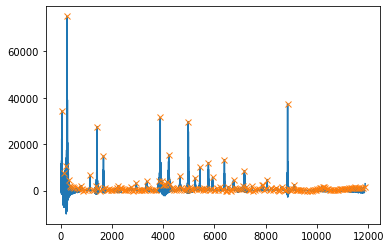

In [38]:
from scipy import signal
peaks, prop = signal.find_peaks(mKappa, height=0, distance=50)
np.diff(peaks)
plt.plot(mKappa)
plt.plot(peaks, mKappa[peaks], "x")
plt.show()


[   43   135   195   250   311   361   411   467   524   621   710   775
   828   880   964  1063  1134  1217  1308  1364  1414  1470  1522  1614
  1666  1720  1795  1845  1896  1947  1999  2084  2141  2191  2243  2295
  2345  2400  2456  2506  2557  2632  2682  2733  2786  2836  2894  2946
  2996  3070  3123  3187  3249  3302  3354  3408  3459  3516  3602  3666
  3725  3830  3884  3935  3991  4047  4112  4163  4214  4264  4325  4381
  4431  4495  4545  4595  4651  4704  4755  4805  4872  4923  4975  5030
  5087  5142  5194  5248  5298  5381  5432  5484  5548  5598  5648  5707
  5763  5817  5876  5926  5980  6030  6082  6132  6232  6285  6338  6388
  6440  6492  6542  6593  6644  6696  6747  6803  6859  6921  7003  7056
  7114  7172  7222  7282  7332  7391  7460  7523  7591  7677  7731  7840
  7892  7942  7997  8060  8168  8220  8275  8356  8411  8463  8514  8567
  8619  8670  8743  8799  8856  8906  8965  9015  9067  9118  9169  9220
  9278  9328  9383  9454  9505  9602  9687  9743  9

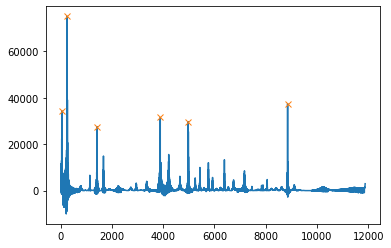

In [39]:
print(peaks)
print(np.sort(prop["peak_heights"])[-1])
print(np.sort(prop["peak_heights"])[-6:])
ind = np.argsort(prop["peak_heights"])[-6:]
print(prop["peak_heights"][ind])
print(peaks[ind])
plt.plot(mKappa)
plt.plot(peaks[ind], mKappa[peaks[ind]], "x")
plt.show()

In [42]:
print(mS[peaks[ind]])
print(peaks[ind])

[1.5365608e-01 2.5688427e-01 2.4556100e-01 1.5674000e-04 9.4676693e-01
 4.5628000e-04]
[1414 4975 3884   43 8856  250]


In [26]:
peakind = signal.find_peaks_cwt(mKappa, np.arange(60,80))
plt.plot(mKappa)
plt.plot(peakind, mKappa[peakind], "x")
plt.show()

KeyboardInterrupt: 

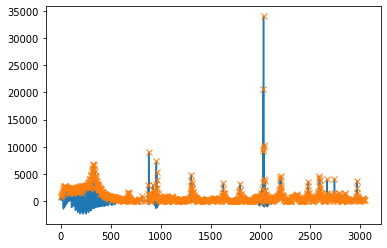

In [84]:
extrema = signal.argrelmax(mKappa,)[0]
plt.plot(mKappa)
plt.plot(extrema, mKappa[extrema], "x")
plt.show()


In [ ]:
plot_array_2D(mS, np.array([f_interp_kappa(mS), mKappa]), '')


In [ ]:
SmoothThetaFP = FrenetPath(Q_GS.grid_obs[:-1], Q_GS.grid_obs[:-1], init=Q_GS.data[:,:,0], curv=f, tors=f_interp_tau, dim=3)
SmoothThetaFP.frenet_serret_solve()
plot_3D_means([np.transpose(cumtrapz(Q_GS.data[:,0,:], Q_GS.grid_obs, initial=0))*X.L, SmoothThetaFP.data_trajectory*X.L], [], " ", "")

In [ ]:
import pywt 

coeffs = pywt.wavedec(mKappa, 'db2', level=1)
reconstructed_signal = pywt.waverec(coeffs, 'db2')
 
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(mKappa[:], label='signal')
ax.plot(reconstructed_signal[:], label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

In [ ]:
# (cA1, cD1) = pywt.cwt(mKappa, 1, 'gaus1')
# reconstructed_signal = pywt.idwt(cA1, cD1, 'gaus1', 'smooth')
 
# fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(mKappa, label='signal')
# ax.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
# ax.legend(loc='upper left')
# plt.show()

In [ ]:
print(pywt.wavelist(kind='discrete'))

In [ ]:
def lowpassfilter(signal, thresh = 0.9, wavelet="db38"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(mKappa, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(mKappa, 0.001)
ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()



In [ ]:
f = interp1d(mS, rec[:-1])

In [ ]:
plot_array_2D(mS, np.array([mKappa, f(mS)]), '')

In [ ]:
from statsmodels.robust import scale

coeff = pywt.wavedec(mKappa, wavelet="db2", mode="per" )
sigma = scale.mad(coeff[-1])
uthresh = sigma*np.sqrt(2*np.log(len(mKappa)))

denoised = coeff[:]

denoised[1:] = (pywt.threshold(i, value=uthresh, mode="soft") for i in denoised[1:])

signal = pywt.waverec(denoised, 'db2', mode='per')

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True,
                         figsize=(10,8))
ax1, ax2 = axes

ax1.plot(signal)
ax1.set_xlim(0,2000)
ax1.set_title("Recovered Signal")
ax1.margins(.1)

ax2.plot(mKappa)
ax2.set_title("Noisy Signal")

for ax in fig.axes:
    ax.tick_params(labelbottom=False, top=False, bottom=False, left=False, 
                 right=False)
    
fig.tight_layout()

In [ ]:
# t_bornes = [0.2,0.85]
print(len(mS))
s_lim = [0.02, 0.97]
ind_bornes = np.intersect1d(np.where(mS>s_lim[0]), np.where(mS<s_lim[1]))
print(len(ind_bornes))

In [ ]:
mS_cut = mS[ind_bornes]
mKappa_cut = mKappa[ind_bornes]
mTau_cut = mTau[ind_bornes]
plot_2D(mS_cut, mKappa_cut)
plot_2D(mS_cut, mTau_cut)

In [ ]:
lbda1 = 1e-30
lbda2 = 1e-30
curv_smoother = BasisSmoother(domain_range=(s_lim[0],s_lim[1]), nb_basis=3000)
tors_smoother = BasisSmoother(domain_range=(s_lim[0],s_lim[1]), nb_basis=3000)
Model_theta = Model(curv_smoother, tors_smoother)
theta_curv = Model_theta.curv.smoothing(mS_cut, mKappa_cut, mOmega[ind_bornes], lbda1)
theta_torsion = Model_theta.tors.smoothing(mS_cut, mTau_cut, mOmega[ind_bornes], lbda2)

In [ ]:
plot_2D(mS, mKappa)
plot_2D(np.linspace(0,mS[-1],1000), f(np.linspace(0,mS[-1],1000)))
plot_2D(np.linspace(0,mS[-1],1000), Model_theta.curv.function(np.linspace(0,mS[-1],1000)))

In [ ]:
plot_2D(mS_cut, Model_theta.curv.function(mS_cut))
plot_2D(mS_cut, Model_theta.tors.function(mS_cut))
mKappa_cut_bis_bis = Model_theta.curv.function(mS_cut)
mTau_cut_bis_bis = Model_theta.tors.function(mS_cut)

In [ ]:
SmoothThetaFP = FrenetPath(Q_GS.grid_obs, Q_GS.grid_obs, init=Q_GS.data[:,:,0], curv=Model_theta.curv.function, tors=Model_theta.curv.function, dim=3)
SmoothThetaFP.frenet_serret_solve()

In [ ]:
plot_3D_means([np.transpose(cumtrapz(Q_GS.data[:,0,:], Q_GS.grid_obs, initial=0))*X.L, SmoothThetaFP.data_trajectory*X.L], [], " ", "")

In [ ]:
threshold = 1e-1000
abs_Tau = np.abs(mTau_cut_bis)
ind_pos = np.intersect1d(np.where((abs_Tau>threshold)), np.where((mKappa_cut_bis>threshold)))
# ind_pos = np.intersect1d(ind_pos, ind_bornes)
t_new = np.linspace(0,1,3000)
invS = interp1d(X.S(t_new), t_new)
print(mS[0], mS[-1])
mt = invS(mS[ind_bornes])
log_v = np.log(X.Sdot(mt))[ind_pos]
log_tau = np.log(abs_Tau[ind_pos])
log_kappa = np.log(mKappa_cut_bis[ind_pos])

In [ ]:
plot_2D(mt, X.Sdot(mt))
plot_2D(mt, mKappa)
plot_2D(mt, mTau)

In [ ]:
plot_2D(mt[ind_pos], log_v)
plot_2D(mt[ind_pos], log_kappa/log_v)
# plot_array_2D(mt[ind_pos], np.array([log_v, 10-1/3*log_kappa-1/6*log_tau]), '')
plot_2D(mt[ind_pos], log_tau)
plot_array_2D(mt[ind_pos], np.array([log_v, 8.-1/6*log_tau-1/3*log_kappa]), '')

# Regression

In [ ]:
from sklearn.linear_model import LinearRegression
y = log_v

- ### kappa tau PL

In [ ]:
x = np.stack((log_tau, log_kappa),1)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

In [ ]:
plot_array_2D(mt[ind_pos], np.array([log_v, model.intercept_ + model.coef_[0]*log_tau + model.coef_[1]*log_kappa]), '')

- ### kappa PL

In [ ]:
x = log_kappa
x = x.reshape(-1, 1)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

In [ ]:
plot_array_2D(mt[ind_pos], np.array([log_v, model.intercept_ + model.coef_[0]*log_kappa]), '')

- ### c kappa tau PL

In [ ]:
x = log_kappa + 1/2*log_tau
x = x.reshape(-1, 1)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

In [ ]:
plot_array_2D(mt[ind_pos], np.array([log_v, model.intercept_ + model.coef_[0]*x[:,0]]), '')

- ### Tot kappa PL

In [ ]:
x = 1/2*np.log(abs_Tau[ind_pos]**2+mKappa[ind_pos]**2)
x = x.reshape(-1, 1)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

In [ ]:
plot_array_2D(mt[ind_pos], np.array([log_v, model.intercept_ + model.coef_[0]*x[:,0]]), '')

In [ ]:
x = np.linspace(0,2*np.pi,200)
x = x[:,np.newaxis]
y = np.sin(x) + 5
gam = LinearGAM(s(0), verbose=True)
gam.gridsearch(x, y)
gam.summary()
# gam.accuracy(x, y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

# plt.scatter(x, y, facecolor='gray', edgecolors='none')
# plt.title('95% prediction interval')
plt.figure()
plt.scatter(y, gam.predict(x))
plt.xlabel('true')
plt.ylabel('predicted')

In [ ]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))
print(gam.coef_[-1])


In [ ]:
from pygam import LinearGAM, s

mt_cut = invS(mS_cut)
y = np.log(X.Sdot(mt_cut))
# y = X.Sdot(mt_cut)
# x = np.stack((mKappa_cut_bis_bis, mTau_cut_bis_bis), 1)
x = np.stack((mKappa_cut, mTau_cut), 1)
# x = mKappa_cut_bis_bis**2 + mTau_cut_bis_bis**2
# x = x[:,np.newaxis]
print(x.shape, y.shape)
gam = LinearGAM(s(0) + s(1), verbose=True)
# gam = LinearGAM(s(0), verbose=True)
gam.gridsearch(x, y)
gam.summary()
# gam.accuracy(x, y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

# plt.scatter(x, y, facecolor='gray', edgecolors='none')
# plt.title('95% prediction interval')
plt.figure()
plt.scatter(y, gam.predict(x))
plt.xlabel('true')
plt.ylabel('predicted')

In [ ]:
print(gam.coef_[-1])

In [ ]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

In [ ]:
plt.plot(mt_cut, y)
plt.plot(mt_cut, gam.predict(x))

In [ ]:
bornes_s = [0.1199, 0.3259, 0.437, 0.662, 0.948]
ind_part = []
for i in range(len(bornes_s)-1):
    ind_part.append(np.intersect1d(np.where(mS_cut>bornes_s[i]), np.where(mS_cut<bornes_s[i+1])))
part = []
for i in range(len(bornes_s)-1):
    part.append({"y" : y[ind_part[i]], "x" : x[ind_part[i],:]})

In [ ]:
for i in range(len(bornes_s)-1): 
    gam = LinearGAM(s(0) + s(1))
    gam.gridsearch(part[i]["x"], part[i]["y"])
    gam.summary()
    plt.figure()
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        plt.plot(gam.partial_dependence(term=i))
    plt.figure()
    plt.scatter(y, gam.predict(x))
    plt.xlabel('true')
    plt.ylabel('predicted')

In [13]:
filename = "gam_LSFtraj_raw_abs"
fil = open(filename,"rb")
dic = pickle.load(fil)
fil.close()

In [18]:
gam_array = dic["gam_array"]
N = len(gam_array)
for i in range(N):
    print(gam_array[i].summary())

f1_array = np.zeros((N,100))
f2_array = np.zeros((N,100))
for i in range(N):
    f1_array[i] = gam_array[i].partial_dependence(term=0)
    f2_array[i] = gam_array[i].partial_dependence(term=1)
plot_array_2D(np.linspace(0,1,100), f1_array, '')
plot_array_2D(np.linspace(0,1,100), f2_array, '')
plot_2D(np.linspace(0,1,100), np.mean(f1_array, axis=0))
plot_2D(np.linspace(0,1,100), np.mean(f2_array, axis=0))
# plt.figure()
# for i in range(N):
#     plt.plot(gam_array[i].partial_dependence(term=0))
# plt.show()

# plt.figure()
# for i in range(N):
#     plt.plot(gam_array[i].partial_dependence(term=1))
# plt.show()

for i in range(N):
    print(gam_array[i].coef_[1])

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.8055
Link Function:                     IdentityLink Log Likelihood:                               -241513.5482
Number of Samples:                       183542 AIC:                                           483086.7075
                                                AICc:                                          483086.7175
                                                GCV:                                                0.3363
                                                Scale:                                              0.3362
                                                Pseudo R-Squared:                                   0.4443
Feature Function                  Lam

<ipython-input-18-1023291a7aa3>:4: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




5.581044038626082
3.986767774236277
-12.958122447584511
-2.1745473000860307
-0.25487905789132975
-14.019961620804542
-23.373223511739983
-7.747173532887479
6.818212593653673
-0.08867066310358782
5.949827537062163
6.863387020585093
2.069667133559527
9.012564416553047
8.84398014470408
-28.823373761086756
10.77430746141203
7.668723890406851
14.071122097558554
-4.0054892236857675
8.555111941694912
6.887936863452741
3.733891298512535
2.9462450576332473
-0.8628620425260997
4.652549377801396
-1.9200302624176495
-0.40151689840185295
11.003871754007678
-17.343060400256345
3.750457109025672
8.042783866378613
7.9720271135890215
13.978110911492365
9.407971633532886
3.553045558640495
5.297667379586241
-11.432615729641261
-3.234153364633122
4.848355899419626
-26.099049095146935
-16.842311600472637
2.2840727110316505
3.9090326113322833
1.4665794516150006
-7.998721031743139
9.859133862011067
12.270962561643813
4.9250484544425985
11.551207261195543
-4.777316790834707
-11.482008536084631
9.3857707654503